In [1]:
%matplotlib inline

/Users/MichaelMa/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

In [3]:
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [4]:
# Some constants 
INPUT_FOLDER = './Data/sample_images/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

In [5]:
patients

['.DS_Store',
 '0a099f2549429d29b32f349e95fb2244',
 '0a0c32c9e08cc2ea76a71649de56be6d',
 '0a38e7597ca26f9374f8ea2770ba870d']

In [6]:
# Load the scans in given folder path
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    
    # This works because of DICOM definiion
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    
    # Slick thickness is important in later resampling
    for s in slices:
        s.SliceThickness = slice_thickness
    
    return slices

In [12]:
slices = load_scan('./Data/sample_images/' + patients[1])

In [13]:
for s in slices:
    print(s.ImagePositionPatient)

['-191.300003', '-179.199997', '-337.880005']
['-191.300003', '-179.199997', '-335.380005']
['-191.300003', '-179.199997', '-332.880005']
['-191.300003', '-179.199997', '-330.380005']
['-191.300003', '-179.199997', '-327.880005']
['-191.300003', '-179.199997', '-325.380005']
['-191.300003', '-179.199997', '-322.880005']
['-191.300003', '-179.199997', '-320.380005']
['-191.300003', '-179.199997', '-317.880005']
['-191.300003', '-179.199997', '-312.880005']
['-191.300003', '-179.199997', '-310.380005']
['-191.300003', '-179.199997', '-307.880005']
['-191.300003', '-179.199997', '-305.380005']
['-191.300003', '-179.199997', '-302.880005']
['-191.300003', '-179.199997', '-300.380005']
['-191.300003', '-179.199997', '-297.880005']
['-191.300003', '-179.199997', '-295.380005']
['-191.300003', '-179.199997', '-292.880005']
['-191.300003', '-179.199997', '-290.380005']
['-191.300003', '-179.199997', '-287.880005']
['-191.300003', '-179.199997', '-285.380005']
['-191.300003', '-179.199997', '-2

In [14]:
dir(slices[0])

['AcquisitionNumber',
 'BitsAllocated',
 'BitsStored',
 'Columns',
 'FrameOfReferenceUID',
 'HighBit',
 'ImageOrientationPatient',
 'ImagePositionPatient',
 'InstanceNumber',
 'KVP',
 'Modality',
 'PatientBirthDate',
 'PatientID',
 'PatientName',
 'PatientOrientation',
 'PhotometricInterpretation',
 'PixelData',
 'PixelPaddingValue',
 'PixelRepresentation',
 'PixelSpacing',
 'PositionReferenceIndicator',
 'RescaleIntercept',
 'RescaleSlope',
 'Rows',
 'SOPClassUID',
 'SOPInstanceUID',
 'SamplesPerPixel',
 'SeriesDescription',
 'SeriesInstanceUID',
 'SeriesNumber',
 'SliceLocation',
 'SliceThickness',
 'SpecificCharacterSet',
 'StudyInstanceUID',
 'WindowCenter',
 'WindowWidth',
 '__cmp__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__init__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setatt

In [15]:
np.array([s.pixel_array for s in slices]).shape

(118, 512, 512)

In [16]:
np.stack([s.pixel_array for s in slices]).shape

(118, 512, 512)

In [17]:
len(slices)

118

In [18]:
def get_pixels_hu(slices):
    #np.array() should also work according to the preceding cells
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    # TODO: Understand what `intercept` and `slope` is
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

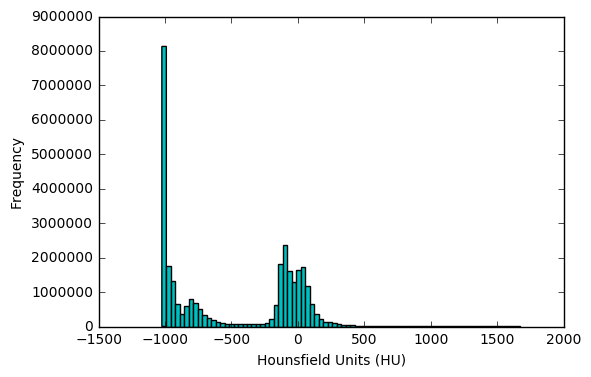

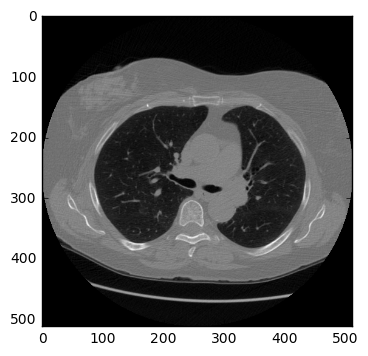

In [23]:
# patients[0] is .DS_Store on a Mac
first_patient = load_scan(INPUT_FOLDER + patients[1])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

In [ ]:
verts, faces = measure.marching_cubes(first_patient_pixels, 400)

In [ ]:
verts.shape

In [ ]:
verts[faces].shape

In [ ]:
verts[faces[0]]

In [ ]:
mesh = Poly3DCollection(verts[faces], alpha=0.1)

In [ ]:
mesh.set_facecolor([0.5, 0.5, 1])

In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot(212, projection='3d')
# ax.add_collection3d(mesh)
# ax.set_xlim(0, first_patient_pixels.shape[0])
# ax.set_ylim(0, first_patient_pixels.shape[1])
# ax.set_zlim(0, first_patient_pixels.shape[2])
# plt.show()

In [20]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    # p = image.transpose(2,1,0)
    p = image
    
    verts, faces = measure.marching_cubes(p, threshold)
    print(verts[faces].shape)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    print(fig)

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [21]:
plot_3d(first_patient_pixels, 400)

NameError: name 'first_patient_pixels' is not defined

In [24]:
scan = first_patient

In [25]:
image = first_patient_pixels

In [22]:
scan[0].SliceThickness

'2.5'

In [23]:
[scan[0].SliceThickness]

['2.5']

In [24]:
scan[0].PixelSpacing

['0.677734', '0.677734']

In [25]:
[scan[0].SliceThickness] + scan[0].PixelSpacing

['2.5', '0.677734', '0.677734']

In [29]:
np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

array([ 2.5       ,  0.67773402,  0.67773402], dtype=float32)

In [30]:
spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

In [32]:
new_spacing = [1, 1, 1]

In [33]:
spacing / new_spacing

array([ 2.5       ,  0.67773402,  0.67773402])

In [31]:
resize_factor = spacing / new_spacing

In [34]:
image.shape

(118, 512, 512)

In [36]:
image.shape * resize_factor

array([ 295.        ,  346.99981689,  346.99981689])

In [43]:
np.round(image.shape * resize_factor)

array([ 295.,  347.,  347.])

In [39]:
new_shape = np.round(new_real_shape)

In [40]:
new_shape / image.shape

array([ 2.5       ,  0.67773438,  0.67773438])

In [44]:
actual_resize_factor = np.round(image.shape * resize_factor) / image.shape

In [45]:
spacing / actual_resize_factor

array([ 1.        ,  0.99999947,  0.99999947])

In [47]:
spacing / actual_resize_factor

array([ 1.        ,  0.99999947,  0.99999947])

In [48]:
actual_new_spacing = spacing / actual_resize_factor

In [49]:
scipy.ndimage.interpolation.zoom(image, actual_resize_factor, mode='nearest')

array([[[-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        ..., 
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024]],

       [[-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        ..., 
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024]],

       [[-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        ..., 
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, 